This is the infer notebook.
For evaluation on training set, refer to [Getting Started Qwen2.5-32b-instruct-awq [eval]](https://www.kaggle.com/code/jiazhuang/getting-started-qwen2-5-32b-instruct-awq-eval)

In [1]:
#| default_exp core

In [2]:
#| export

import vllm

import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree

svg_constraints = kagglehub.package_import('metric/svg-constraints')

INFO 03-28 12:19:46 [__init__.py:239] Automatically detected platform cuda.


In [3]:
#| export

num_attempt = 6

class Model:
    def __init__(self):
        self.model_path = kagglehub.model_download('qwen-lm/qwen2.5/Transformers/32b-instruct-awq/1')
        self.llm = vllm.LLM(
            self.model_path,
            quantization="awq",
            tensor_parallel_size=2,
            gpu_memory_utilization=0.95,
            trust_remote_code=True,
            dtype="half",
            enforce_eager=True,
            max_model_len=5120,
            disable_log_stats=True
        )
        self.sampling_params = vllm.SamplingParams(
            n=1,  # Number of output sequences to return for each prompt.
            top_k=20,  # Float that controls the cumulative probability of the top tokens to consider.
            top_p=0.8,
            temperature=0.7,  # randomness of the sampling
            repetition_penalty=1.05,
            # seed=777, # Seed for reprodicibility
            skip_special_tokens=False,  # Whether to skip special tokens in the output.
            max_tokens=512,  # Maximum number of tokens to generate per output sequence.
        )
        self.tokenizer = self.llm.get_tokenizer()
        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def apply_template(prompt, tokenizer):
            messages = [
                {"role": "user", "content": prompt},
            ]
            text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            return text
        
        def parse_svg_from_response(response):
            matchs = re.findall(r'<svg.*?</svg>', response, re.S)
            if matchs:
                return matchs[-1].strip()
            else:
                return ''
        
        def check_svg_valid(svg):
            try:
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return True
            except:
                return False
        
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)
                inputs = [apply_template(prompt, self.tokenizer)] * num_attempt
                responses = self.llm.generate(inputs, self.sampling_params, use_tqdm=False)
                responses = [x.outputs[0].text for x in responses]
                svgs = [parse_svg_from_response(x) for x in responses]
                # use the first valid svg
                choosen_svg = None
                for svg in svgs:
                    if check_svg_valid(svg):
                        svg = self.enforce_constraints(svg)
                        if check_svg_valid(svg):
                            choosen_svg = svg
                            break
                
                assert choosen_svg is not None
                return svg

            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                return self.default_svg
        
        return generate_svg()

        # # Execute SVG generation in a new thread to enforce time constraints
        # with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        #     future = executor.submit(generate_svg)
        #     try:
        #         return future.result(timeout=self.timeout_seconds)
        #     except concurrent.futures.TimeoutError:
        #         logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
        #         return self.default_svg
        #     except Exception as e:
        #         logging.error(f"An unexpected error occurred: {e}")
        #         return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

In [4]:
model = Model()

INFO 03-28 12:20:00 [config.py:585] This model supports multiple tasks: {'reward', 'classify', 'embed', 'generate', 'score'}. Defaulting to 'generate'.
WARNING 03-28 12:20:02 [config.py:664] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
WARNING 03-28 12:20:02 [arg_utils.py:1854] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 03-28 12:20:02 [config.py:1519] Defaulting to use mp for distributed inference
WARNING 03-28 12:20:02 [cuda.py:95] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 03-28 12:20:02 [llm_engine.py:241] Initializing a V0 LLM engine (v0.8.2) with config: model='/kaggle/input/qwen2.5/transformers/32b-instruct-awq/1', speculative_config=None, tokenizer='/kaggle/input/qwen2.5/transformers/32b-instruct-awq/1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=Non

Loading safetensors checkpoint shards:   0% Completed | 0/5 [00:00<?, ?it/s]


(VllmWorkerProcess pid=83) INFO 03-28 12:23:28 [loader.py:447] Loading weights took 153.32 seconds
INFO 03-28 12:23:29 [loader.py:447] Loading weights took 153.58 seconds
(VllmWorkerProcess pid=83) INFO 03-28 12:23:29 [model_runner.py:1146] Model loading took 9.0925 GB and 153.601594 seconds
INFO 03-28 12:23:29 [model_runner.py:1146] Model loading took 9.0925 GB and 153.854572 seconds
(VllmWorkerProcess pid=83) INFO 03-28 12:23:45 [worker.py:267] Memory profiling takes 15.33 seconds
(VllmWorkerProcess pid=83) INFO 03-28 12:23:45 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.95) = 14.00GiB
(VllmWorkerProcess pid=83) INFO 03-28 12:23:45 [worker.py:267] model weights take 9.09GiB; non_torch_memory takes 0.12GiB; PyTorch activation peak memory takes 0.73GiB; the rest of the memory reserved for KV Cache is 4.06GiB.
INFO 03-28 12:23:45 [worker.py:267] Memory profiling takes 15.46 seconds
INFO 03-28 12:23:45 [worker.py:267] the curre

## Generate on training data

In [5]:
from IPython.display import SVG, display

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [6]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')

In [7]:
train_df.head()

,id,description
0,02d892,a purple forest at dusk
1,0dcd2e,gray wool coat with a faux fur collar
2,1e9ac1,a lighthouse overlooking the ocean
3,2b25db,burgundy corduroy pants with patch pockets and...
4,4e6a54,orange corduroy overalls


In [8]:
r = train_df.iloc[2]
r.description

'a lighthouse overlooking the ocean'

In [9]:
%%time
svg = model.predict(r.description)

CPU times: user 38.9 s, sys: 418 ms, total: 39.3 s
Wall time: 39.9 s


In [10]:
train_df['svg'] = train_df.description.progress_apply(model.predict)

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
train_df.to_json('train_svg.jsonl', orient='records', lines=True, force_ascii=False)

## Display

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from PIL import Image
import cairosvg

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

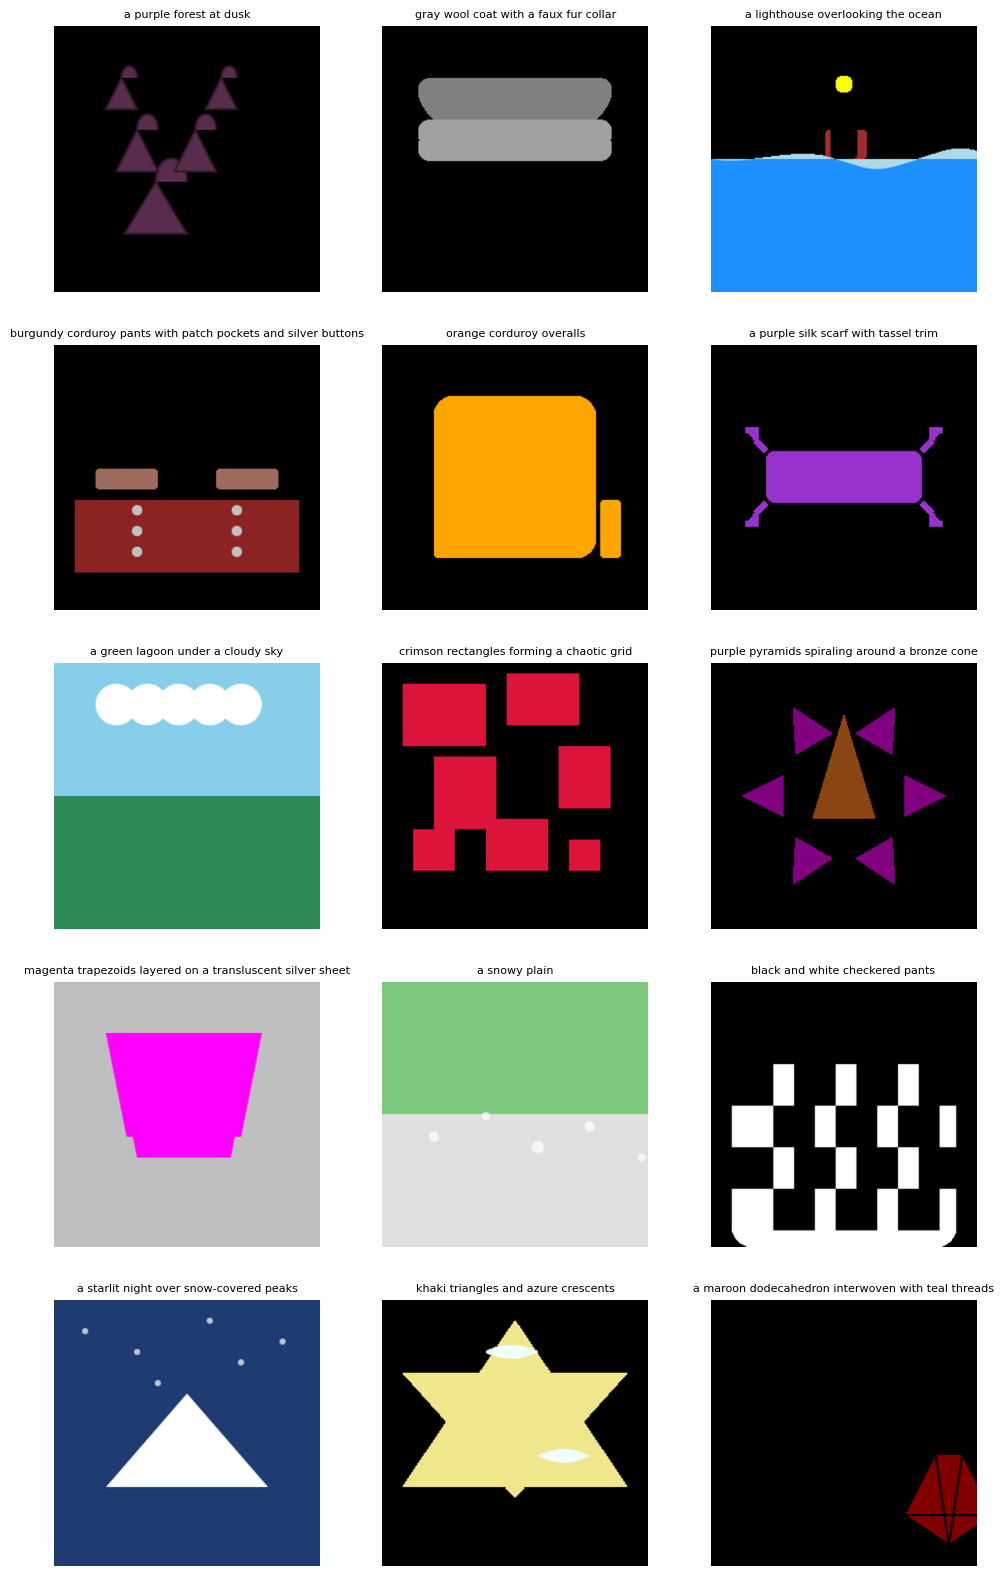

In [14]:
plt.figure(figsize=(12, 20))
for i, r in enumerate(train_df.itertuples(), 1):
    plt.subplot(5, 3, i)
    img = svg_to_png(r.svg)
    plt.imshow(img)
    plt.axis('off')
    plt.title(r.description, fontdict={'fontsize': 8})